In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

In [22]:
def nu_int(r_lim, k):
    x = r_lim
    #print ((k-1)*((k**2-6*k+6.)))
    #print ((k**2-3*k+2)*np.power(x,2)+2*(k-1.)*x+2)
    return -np.power((x+1.), (1-k))*((k**2-3*k+2)*np.power(x,2)+2*(k-1.)*x+2)/((k-1)*(k**2-5*k+6.))
def nuProfile(Ntot,radii,k=-3.):
    nu0 = Ntot / (4.*np.pi*nu_int(radii[-1], k)-nu_int(0., k))
    print nu0
    return (nu0*(nu_int(radii[1:],k) - nu_int(radii[:-1],k))).astype(int)

radii = np.append(0,np.logspace(-2,1.,11))
radii = np.linspace(0,10, 11)
print radii
#plt.xscale('log')
#plt.yscale('log')
#plt.plot(radii[1:],nuProfile(1000,radii),'b+')
print np.sum(nuProfile(1000,radii))
print nuProfile(1000,radii)
#plt.plot(np.power((1+np.linspace(0,10,10)),-3))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
0.000339349536632
76
0.000339349536632
[ 0  0  0  0  1  2  6 11 21 35]


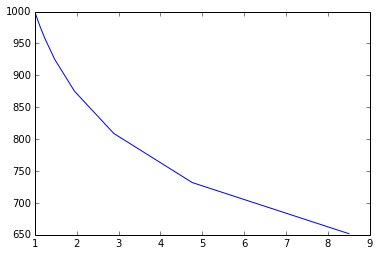

In [19]:
def sigmaProfile(radii,sigMax=1000,k=-.2):
    
    return sigMax*(1.+0.5*(radii[1:]+radii[:-1]))**k

plt.plot(1.+0.5*(radii[1:]+radii[:-1]),sigmaProfile(radii))

In [4]:
def createMockData(radii,Ntot=1000,sigMax=1000,kindex=-3,sigmaindex=-0.2): #total Ngals, no of shells
    clusterData = np.zeros((Ntot,5))
    counter=0
    density = nuProfile(Ntot,radii,k=kindex)
    sig = sigmaProfile(radii,sigMax=1000,k=sigmaindex)
    
    for shell,dens in enumerate(density):
        #generate positions
        phi = np.random.uniform(0.,2*np.pi,dens)
        cosTheta = np.random.uniform(-1,1,dens)
        theta = np.arccos(cosTheta)
        u = np.random.uniform(radii[shell]**3,radii[shell+1]**3,dens) #cuberoot([rin,rout])
        r = np.power(u,1./3)
        
        x = r*np.sin(theta)*np.cos(phi)
        y = r*np.sin(theta)*np.sin(phi)
        z = r*cosTheta
        
        #generate velocities
        
        speed = sig[shell]*np.random.randn(dens)
        #phi = np.random.uniform(0.,2*np.pi,dens)
        cosTheta = np.random.uniform(-1,1,dens)
        #theta = np.arccos(cosTheta)
        
        v=speed*cosTheta   
        
        #replace with vstack,append
        clusterData[counter:counter+dens]=np.hstack((shell*np.ones(dens).reshape((dens,1)),x.reshape((dens,1)),y.reshape((dens,1)),z.reshape((dens,1)),v.reshape((dens,1))))
        counter += dens
    
    print counter
    return clusterData[:counter],density,sig

994
[  0.01         0.01995262   0.03981072   0.07943282   0.15848932
   0.31622777   0.63095734   1.25892541   2.51188643   5.01187234  10.        ]


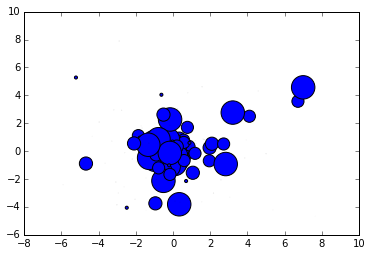

In [5]:
cluster,density,sigma = createMockData(np.append(0,np.logspace(-2,1,11)))

print np.logspace(-2,1,11)

plt.scatter(cluster[:,1],cluster[:,2],s=np.fabs(cluster[:4])/5)

In [6]:
import pandas as pd

clusterPd = pd.DataFrame(cluster)

clusterPd.describe()

,0,1,2,3,4
count,994.000000,994.000000,994.000000,994.000000,994.000000
mean,5.693159,-0.025881,-0.024694,-0.038884,52.580055
std,2.078862,0.979960,0.956779,1.003943,741.213093
min,0.000000,-5.908787,-4.680436,-7.796008,-3133.809266
25%,4.000000,-0.211761,-0.218818,-0.170836,-273.311379
50%,6.000000,-0.003869,-0.004193,-0.000696,14.626836
75%,7.000000,0.144071,0.165231,0.156901,348.657303
max,10.000000,7.653392,8.014847,8.520169,4572.619881


In [7]:
clusterPd.to_csv('mock_cluster.csv')